# Travail sur la ponctualité des trains

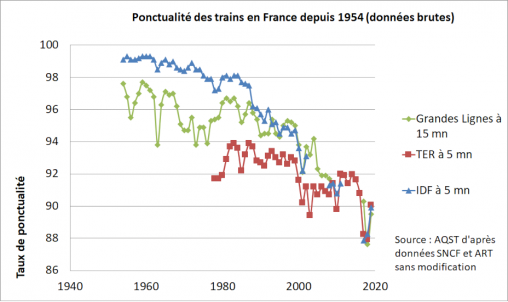

In [2]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import math
import numpy as np
import re
import matplotlib.pyplot as plt
import pprint
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
from sklearn import svm
import numpy as np
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [ ]:

#si erreur "Max retries exceeded with url"

import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

session = requests.Session()
retry = Retry(connect=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

session.get(url_retards)


In [5]:
url_retards ='https://ressources.data.sncf.com/api/v2/catalog/datasets/regularite-mensuelle-tgv-aqst/exports/json?limit=-1&offset=0&timezone=UTC'
retards = requests.get(url_retards)
wb_retards = retards.json()

df_retards = pd.DataFrame(wb_retards)
df_retards.head(2)

ConnectionError: HTTPSConnectionPool(host='ressources.data.sncf.com', port=443): Max retries exceeded with url: /api/v2/catalog/datasets/regularite-mensuelle-tgv-aqst/exports/json?limit=-1&offset=0&timezone=UTC (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f00f3df40d0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))

In [ ]:
df_retards['nb_retards'] = df_retards['nb_train_retard_sup_15']+df_retards['nb_train_retard_sup_30']+df_retards['nb_train_retard_sup_60']


In [ ]:
df_retards['prct_nb_train_depart_retard'] = df_retards['nb_train_depart_retard']/df_retards['nb_train_prevu']*100
df_retards['prct_nb_annulation'] = df_retards['nb_annulation']/df_retards['nb_train_prevu']*100
df_retards[['annee','mois']]=df_retards.date.str.split('-',expand=True)
df_retards.head(2)

In [ ]:
df_retards = df_retards.drop('commentaire_annulation', axis = 1)
df_retards = df_retards.drop('commentaire_retards_depart', axis = 1)
df_retards = df_retards.drop('commentaires_retard_arrivee', axis = 1)
df_retards['annee'] = pd.to_numeric(df_retards['annee'])
df_retards['mois'] = pd.to_numeric(df_retards['mois'])

In [ ]:
df_retards.dropna(inplace = True)
df_retards = df_retards.drop(df_retards[df_retards['retard_moyen_depart']==0].index)
df_retards['log_retard_moyen_depart'] = np.log(df_retards['retard_moyen_depart'])
plt.hist(df_retards['log_retard_moyen_depart'])


In [ ]:
df_retards_initial = df_retards
df_retards_initial

In [ ]:
df_retards = df_retards.groupby(['date'])[['duree_moyenne','log_retard_moyen_depart','prct_cause_materiel_roulant', 'prct_cause_infra','prct_cause_gestion_trafic','nb_train_prevu', 'prct_cause_externe','prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs', 'nb_retards']].sum()
df_retards.head()


<font color='blue'> **Première regression à une varaible** </font>

In [ ]:
x = df_retards[['prct_cause_gestion_gare']]
y = df_retards[['duree_moyenne']].values.ravel()

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2)
xTest

In [ ]:
#on fait la regression lineaire
reg = LinearRegression()
reg.fit(xTrain, yTrain) #estime les coeffs
reg.coef_
reg.intercept_

In [ ]:
#puis on predit les resultats
yPred = reg.predict(xTrain)
yPred

In [ ]:
epsilon = yTrain - yPred

In [ ]:
plt.scatter(yTrain, epsilon)

<font color='blue'> **On ajoute maintenant des variables explicatives** </font>

<font color='blue'> **1. Regression linéaire** </font>

In [ ]:
x = sm.add_constant(df_retards[['prct_cause_materiel_roulant', 'prct_cause_infra','prct_cause_gestion_trafic','nb_train_prevu', 'prct_cause_externe','prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']])
y = df_retards[['duree_moyenne']].values.ravel()

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2)
xTest

In [ ]:
#on fait la regression lineaire

results = sm.OLS(y, x).fit()
print(results.summary())

In [ ]:
#On évaluer la pertinence du modèle

# R^2: 1 corresponf à une prédiction parfaite
print("R2: ", results.rsquared)

In [ ]:
#puis on predit les resultats
#yPred = sm.predict(xTrain)
yPred = results.predict(xTest)
epsilon = yTest - yPred


In [ ]:
#Nuage de points des valeurs observées
tempdf = pd.DataFrame({"prediction": yPred, "observed": yTest,
                       "epsilon": yTest - yPred})

fig = plt.figure()
g = sns.scatterplot(data = tempdf, x = "observed", y = "epsilon")
g.axhline(0, color = "red")


<font color='blue'> **2. Regression logistique** </font>

In [ ]:
clf = LogisticRegression().fit(xTrain, yTrain)
yPred = clf.predict(xTrain)
#y_pred[:10]
print(clf.intercept_, clf.coef_)

In [528]:
x = df_retards[['prct_cause_materiel_roulant', 'prct_cause_infra','prct_cause_gestion_trafic','nb_train_prevu', 'prct_cause_externe','prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']]
y = df_retards[['nb_retards']].values.ravel()

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, train_size=0.8)
xTest

,prct_cause_materiel_roulant,prct_cause_infra,prct_cause_gestion_trafic,nb_train_prevu,prct_cause_externe,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
date,,,,,,,
2019-04,2628.787949,2865.023968,3148.022920,32063,2279.030037,874.014173,305.120953
2021-08,2251.334251,1732.522013,1715.503267,34949,2279.647833,1164.274726,2556.717910
2021-09,1693.718039,2216.445857,1636.885080,32913,2432.209549,1401.813405,2218.928070
2020-01,2382.636523,3184.748355,2886.024181,26940,2657.967960,910.108125,278.514857
2022-01,2653.845038,2439.955820,1724.219769,35392,2684.177350,742.130564,1755.671460
2020-04,193.803419,3958.448573,300.000000,3325,367.249808,210.972222,969.525978
2022-04,2217.713333,2034.248562,2233.278608,36447,3146.451577,929.372984,1338.934936
2020-06,2076.838076,3936.604938,1435.175105,21908,2662.439468,886.928618,302.013796
2021-04,2059.965914,2098.047422,989.023270,31302,3695.365848,926.768820,1430.828726


In [529]:
#on fait la regression lineaire
reg = LinearRegression()
reg.fit(xTrain, yTrain) #estime les coeffs
coef_nb_retards = reg.coef_
#reg.intercept_

In [530]:
#puis on predit les resultats
yPred = reg.predict(xTrain)
epsilon = yTrain - yPred
#on regarde si le score est satisfaisant
reg.score(xTrain, yTrain)

0.4837898829153695

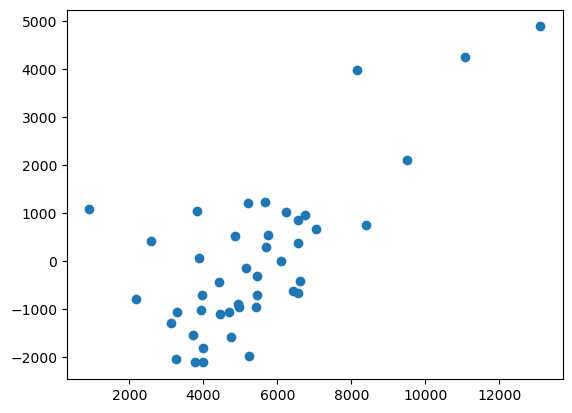

In [531]:
plt.scatter(yTrain, epsilon)

<font color='blue'> **Autre regression : le nombre de retards** </font>

In [532]:
causes_retards = ['prct_cause_materiel_roulant', 'prct_cause_infra','prct_cause_gestion_trafic','nb_train_prevu', 'prct_cause_externe','prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']

In [533]:
dico_duree_retards = dict(zip(causes_retards, coef_duree_retards))
dico_nb_retards = dict(zip(causes_retards, coef_nb_retards))
pprint.pprint(dico_duree_retards)
print()
pprint.pprint(dico_nb_retards)


{'nb_train_prevu': 0.027645003520915035,
 'prct_cause_externe': 1.5884259668179006,
 'prct_cause_gestion_gare': 1.4041766149398773,
 'prct_cause_gestion_trafic': 1.2817961062396814,
 'prct_cause_infra': 1.638090612430986,
 'prct_cause_materiel_roulant': 1.787477927948914,
 'prct_cause_prise_en_charge_voyageurs': 1.543706372920416}

{'nb_train_prevu': 0.2489668341171949,
 'prct_cause_externe': -1.1103712616972328,
 'prct_cause_gestion_gare': 0.6460479890059307,
 'prct_cause_gestion_trafic': -0.22643464553832643,
 'prct_cause_infra': -1.680132606631107,
 'prct_cause_materiel_roulant': -1.061622012567804,
 'prct_cause_prise_en_charge_voyageurs': -1.733859961291452}


- les nombres de retards sont moins bien prédits que les durées de retard par le modèle 
- les problèmes de materiel roulant sont ce qui causent les retards les plus importants (en durée)
- à priori, les problèmes de gestion de gare sont ce qui causent le plus de retards 


**a faire : reprendre ce travail de regression en suivant les etapes des exercices 3 et 4 de la partie 3 du cours**